<a href="https://colab.research.google.com/github/morwald/ada_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gender distribution in UK's leading newspapers

This notebook serves as a first presentation of our project for milestone 2. It is structured and written in such  a way that we can directly continue on it for milestone 3.

## Content
1. [Setup](#setup)   
    1.1 [Imports](#imports)  
    1.2 [Data paths](#data_paths)   
    1.3 [Utility functions](#utility_functions)   
2. [Data preparation and cleaning](#data_prep)    
    2.1 [Columns and rows selection](#cols_rows_select)  
    2.2 [News paper selection](#newspaper_select)
3. [Additional data set: speaker attributes](#additional_dataset)    
    3.1 [Explore attributes](#explore_attr)  
    3.2 [Merge speaker attributes](#merge_speaker_attr)    
    3.3 [Save cleaned data as pickle](#save_pickle)                
4. [Research questions](#research_question)

## 1. Setup
<a id="setup"></a>

### 1.1 Imports
<a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import json
import bz2
import seaborn as sns

### 1.2 Data paths
<a id="data_paths"></a>

**Important**: When using Google Colab the ```use_colab``` variable has to be set to true. This way the files can be accessed directly from our shared drive. If you wan't to work locally the raw and filtered data have to be stored locally in the root folder under _Quotebank_ and _Filtered data_. The finally merged and cleaned data will be stored in _Cleaned data_. To execute section the [Data preparation and cleaning](#data_prep) the raw data in the folder _Quotebank_ is needed but this section has to be executed only once.

You can download the raw data here: [Quotebank](https://zenodo.org/record/4277311#.YYzk6_oo9hE)

The addtional dataset can be found here: [Speakers](https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0)

In [2]:
# Comment the files which aren't stored locally
# In Colab everything should be available
RAW_QUOTES_2020_PATH = 'Quotebank/quotes-2020.json.bz2' 
FILTERED_QUOTES_2020_PATH = 'Filtered data/quotes-2020-gb.json.bz2'
QUOTES_2020_PATH = 'Cleaned data/quotes-2020-gb.pkl'

#RAW_QUOTES_2019_PATH = 'Quotebank/quotes-2019.json.bz2' 
FILTERED_QUOTES_2019_PATH = 'Filtered data/quotes-2019-gb.json.bz2'
QUOTES_2019_PATH = 'Cleaned data/quotes-2019-gb.pkl' 

#RAW_QUOTES_2018_PATH = 'Quotebank/quotes-2018.json.bz2' 
FILTERED_QUOTES_2018_PATH = 'Filtered data/quotes-2018-gb.json.bz2'
QUOTES_2018_PATH = 'Cleaned data/quotes-2018-gb.pkl' 

#RAW_QUOTES_2017_PATH = 'Quotebank/quotes-2017.json.bz2' 
FILTERED_QUOTES_2017_PATH = 'Filtered data/quotes-2017-gb.json.bz2' 
QUOTES_2017_PATH = 'Cleaned data/quotes-2017-gb.pkl'

#RAW_QUOTES_2016_PATH = 'raw_data/quotes-2016.json.bz2' 
FILTERED_QUOTES_2016_PATH = 'Filtered data/quotes-2016-gb.json.bz2'
QUOTES_2016_PATH = 'Cleaned data/quotes-2016-gb.pkl'

#RAW_QUOTES_2015_PATH = 'raw_data/quotes-2015.json.bz2' 
FILTERED_QUOTES_2015_PATH = 'Filtered data/quotes-2015-gb.json.bz2'
QUOTES_2015_PATH = 'Cleaned data/quotes-2015-gb.pkl'

# Additional data set
SPEAKER_ATTRIBUTES_PATH = 'Project datasets/speaker_attributes.parquet'
LABELS_WIKIDATA_PATH = 'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'

In [3]:
# Change to true if you want to use google colab
use_colab = True

We mount the drive and go to the our shared directory if necessary.

In [6]:
# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    %cd /content/drive/Shareddrives/ADA-project

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


We have to install an older version of pandas in order to be able to use the 'chunksize' feature in colab.

In [5]:
if use_colab:
    !pip install pandas==1.0.5

    # Reimport
    import pandas as pd
    print(pd.__version__)

1.0.5


### 1.3 Utility functions
<a id="utility_functions"></a>

In [ ]:
def load_mini_version_of_data(path_to_file, chunksize, nb_chunks):
    """
    Returns a mini dataframe from of a bz2 compressed json file.
    :path_to_file   file path as string
    :chunksize      size to iterate
    :nb_chunks      how many chunks
    :return         pandas.DataFrame with chunksize*nb_chunks of rows
    """
    
    curr_chunk = 0
    chunk_list = []
    
    if use_colab:
          for chunk in pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize):
              if curr_chunk == nb_chunks:
                  break
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    else:
      with pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
          for chunk in df_reader:
              if curr_chunk == nb_chunks:
                  break
          
              curr_chunk = curr_chunk + 1
              chunk_list.append(chunk)
    
    df = pd.concat(chunk_list)
    return df

## 2. Data preparation and cleaning
<a id="data_prep"></a>

The quotebank dataset is too large to directly access it with a dataframe. This section provides all the steps to filter the data we need for our analysis. The filtering and preparation is done based on our research question. Please check the README for details. Further explanations will be given under [Research question](#research_question).

The data preperation can be done on a per year basis of the Quotebank data set.

### 2.1 Column and row selection
<a id="cols_rows_select"></a>

In [ ]:
# A quick look at a small subset of the data of the selected year
year_sample_df = load_mini_version_of_data(RAW_QUOTES_2020_PATH, 10000, 10)
year_sample_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


In [ ]:
# How many quotations don't have an assigned speaker?
sum(year_sample_df['speaker'] == 'None')

34316

The cell above shows that there around 1/3 of the quotations are 'None' speakers. As we want to make a gender based study will will not need these rows. This eliminitation will drasticly reduce the size of the data we have to analyse.

Furthermore the colums which aren't of interest for our study are:\
**phase**: We don't care. \
**probas**: We will select the speaker with highest probablity (note that 'None' speakers are already neglected).

### 2.2 Newspaper selection
<a id="nespaper_select"></a>
In a first analysis we will pick quotations of **3** of the top 12 UKs newspapers with the most reach both in prints and digital reach. See [this](https://www.statista.com/statistics/246077/reach-of-selected-national-newspapers-in-the-uk/) statistic for more details.

In [ ]:
# List of selected newspapers and their urls
newspapers_list = [['The Sun', 'thesun.co.uk'], 
                  ['The Guardian', 'theguardian.com'],
                  ['The Times', 'thetimes.co.uk']]

# Dataframe
newspapers_df = pd.DataFrame(newspapers_list, columns = ['name', 'website_url'])
newspapers_df.head()

,name,website_url
0,The Sun,thesun.co.uk
1,The Guardian,theguardian.com
2,The Times,thetimes.co.uk


### 2.3 Filtering raw data
<a id="filter_raw_data"></a>

Following the reasoning above we can extract the infos needed from the compressed file of one year of quotations. Let's create a helper function to check the urls of a quotation:

In [ ]:
def filter_data(path_in, path_out):
  # Loop through all instances of json file and extract the desired rows
  # Save the file in the filtered data directory
  with bz2.open(path_in, 'rb') as s_file:
      with bz2.open(path_out, 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              if instance['speaker'] == 'None':
                  continue
              urls = instance['urls'] # extracting list of links
              newspapers = []
              for url in urls:
                  for name, website_url in zip(newspapers_df['name'],newspapers_df['website_url']):
                      if website_url in url:
                          if name not in newspapers: # to not have any dublicates 
                              newspapers.append(name)
                  instance['newspapers'] = newspapers # updating the sample with domain name
              # We remove unnecessary columns
              instance.pop('probas')
              instance.pop('phase')
              # If there is a newspaper that we want to keep we write the instance to the output file
              if newspapers: 
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                

In [ ]:
#filter_data(RAW_QUOTES_2020_PATH,FILTERED_QUOTES_2020_PATH)

In [ ]:
# We check that the new file contains the right data
filtered_sample_df = load_mini_version_of_data(QUOTES_2020_PATH, 10000, 10)
filtered_sample_df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[Q304349],2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,"[Q20670776, Q20713880, Q7803899, Q7803900]",2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[Q242329],2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[Q5231515],2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,"[Q30693403, Q43130877]",2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


Let's verify if that there are no 'None' speakers:

In [ ]:
filtered_sample_df[filtered_sample_df.speaker=='None'].empty

True

Now let us do this filtering for the remaining data of years 2015-2019.

In [ ]:
#filter_data(RAW_QUOTES_2019_PATH,FILTERED_QUOTES_2019_PATH)
#filter_data(RAW_QUOTES_2018_PATH,FILTERED_QUOTES_2018_PATH)
#filter_data(RAW_QUOTES_2017_PATH,FILTERED_QUOTES_2017_PATH)
#filter_data(RAW_QUOTES_2016_PATH,FILTERED_QUOTES_2016_PATH)
#filter_data(RAW_QUOTES_2015_PATH,FILTERED_QUOTES_2015_PATH)

## 3. Additional data set: speaker attributes
<a id="additional_dataset"></a>

The filtered Quotebank years are ready. The next step consists of integrating speaker attributes from our additional data set.

### 3.1 Explore attributes
<a id="explore_attr"></a>


In [ ]:
# Load speaker attributes in df
speakers_df = pd.read_parquet(SPEAKER_ATTRIBUTES_PATH)
speakers_df.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


Let us first check for duplicates. There seem to be none.

In [ ]:
# Duplicates
duplicates = speakers_df[speakers_df.duplicated(subset='id', keep='first')] 
duplicates.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion


We are mostly interested in the column gender. But let us see which ones we could keep. How many 'None' values do we have?

In [ ]:
# Fraction of lines with 'None' values:
print('gender: ' + str(speakers_df[speakers_df.gender.isnull()].size / speakers_df.size))
print('nationality: ' + str(speakers_df[speakers_df.nationality.isnull()].size / speakers_df.size))
print('occupation: ' + str(speakers_df[speakers_df.occupation.isnull()].size / speakers_df.size))
print('academic_degree: ' + str(speakers_df[speakers_df.academic_degree.isnull()].size / speakers_df.size))
print('ethnic_group: ' + str(speakers_df[speakers_df.ethnic_group.isnull()].size / speakers_df.size))
print('religion ' + str(speakers_df[speakers_df.religion.isnull()].size / speakers_df.size))

gender: 0.21536937853557775
nationality: 0.5896797928352544
occupation: 0.29625691573337004
academic_degree: 0.9889581261268106
ethnic_group: 0.9856023328670853
religion 0.9783254845609769


Unfortunately we have to drop all attributes appart from gender, nationality and occupation. All the other ones have more than 98% 'None' values.

In [ ]:
# Keep the columns gender, nationality and occupation
speakers_df = speakers_df[['id', 'gender', 'nationality', 'occupation']]

We will remove all 'None' genders as this is the most important attribute for our analysis.

In [ ]:
# Remove null genders
speakers_df = speakers_df.drop(speakers_df[speakers_df.gender.isnull()].index)
speakers_df.head()

,id,gender,nationality,occupation
0,Q23,[Q6581097],"[Q161885, Q30]","[Q82955, Q189290, Q131512, Q1734662, Q294126, ..."
1,Q42,[Q6581097],[Q145],"[Q214917, Q28389, Q6625963, Q4853732, Q1884422..."
2,Q1868,[Q6581097],[Q31],"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q..."
3,Q207,[Q6581097],[Q30],"[Q82955, Q15982858, Q18814623, Q1028181, Q1408..."
4,Q297,[Q6581097],[Q29],[Q1028181]


### 3.2 Merge speaker attributes
<a id="merge_speaker_attr"></a>

Now we can merge the speaker attributes in our filtered dataset. First of all we need to load the corresponding labels for the quote id's.



In [ ]:
labels_df = pd.read_csv(LABELS_WIKIDATA_PATH, compression='bz2', index_col='QID')

# We know there will be a missing label in our dataset.
# We'll just add the information in advance...
labels_df.loc['Q6363085'] = labels_df.loc['Q380075']

labels_df.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


To efficiently look up the quids attributes of a speaker we create dictionaries to access the desired quids.

In [ ]:
# Create dictionary for the labels and the attributes gender, nationality and occupation
labels_dict = pd.Series(labels_df.Label, index=labels_df.index)
genders_dict = pd.Series(speakers_df.gender.values, index=speakers_df.id).to_dict()
nationalities_dict = pd.Series(speakers_df.nationality.values, index=speakers_df.id).to_dict()
occupations_dict = pd.Series(speakers_df.occupation.values, index=speakers_df.id).to_dict()

In a first analysis just the first quid will be considered. Thus the quid of the most probable speaker. Below a helper function to achieve this.

In [ ]:
# We want to transform the 'qids' column in a single 'qid' element
def get_single_qid(df_quotes):
  df_copy =  df_quotes.copy()
  df_result =  df_quotes.copy()
  for idx,row in df_copy.iterrows():  
    id_speaker = row.loc['qids'][0] 
    df_result.at[idx,'qids'] = id_speaker

  df_result = df_result.rename(columns={"qids": "qid"})
  return df_result

We need as well a function to translate the quids of one attribute to corresponding label regarding one speaker.

In [ ]:
def translate_qid2label(id_speaker, attr_dict):
  """
    Retrieve quotes speakers attribute, in the order of the quotations DataFrame.
    :id_speaker   First qid of quids column of one row of the quotations dataframe qid
    :attr_dict    dictionary for specified attributes
    :return       attributes as text in a list
  """
  list_attr = []
  
  if id_speaker in attr_dict:
    id_attr_speaker = attr_dict[id_speaker]
    if(id_attr_speaker is not None):
      for id_a in id_attr_speaker:
          attr = labels_dict[id_a] # Attribute value
          list_attr.append(attr)
    else:
      list_attr = None

  return list_attr

Now we can put all these together and apply the above function to all our speaker attributes and quotes.


In [ ]:
def add_speaker_attributes(path_to_file):
  """
    Function takes path of compressed filtered data of oquotebank and adds
    speaker information in new colums
    :path_to_file   first qid of quids column of one row of the quotations dataframe qid
    :return         pandas DataFrame with new columns
  """
  df = pd.read_json(path_to_file, lines=True,compression='bz2')
  # First we get a single qid:
  df = get_single_qid(df)

  genders = df['qid'].apply(lambda i: translate_qid2label(i, genders_dict))
  nationalities = df['qid'].apply(lambda i: translate_qid2label(i, nationalities_dict))
  occupations = df['qid'].apply(lambda i: translate_qid2label(i, occupations_dict))

  df.insert(3, 'gender', genders)
  df.insert(4,'nationality', nationalities)
  df.insert(5,'occupation', occupations)
  return df

In [ ]:
# Merge and speaker attributes for filtered quotes of 2020
df_2020 = add_speaker_attributes(FILTERED_QUOTES_2020_PATH)
df_2020.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


In [ ]:
# Merge speaker attributes of all other years
df_2019 = add_speaker_attributes(FILTERED_QUOTES_2019_PATH)
df_2018 = add_speaker_attributes(FILTERED_QUOTES_2018_PATH)
df_2017 = add_speaker_attributes(FILTERED_QUOTES_2017_PATH)
df_2016 = add_speaker_attributes(FILTERED_QUOTES_2016_PATH)

### 3.3 Save cleaned data as pickle
<a id="save_pickle"></a>

For easier handling we will save the merged dataframes in a pickled format. In this way section 3 doesn't have to be excecuted anymore.

In [ ]:
# Store merged dataframes as pickle
df_2020.to_pickle(QUOTES_2020_PATH)
df_2019.to_pickle(QUOTES_2019_PATH)
df_2018.to_pickle(QUOTES_2018_PATH)
df_2017.to_pickle(QUOTES_2017_PATH)
df_2016.to_pickle(QUOTES_2016_PATH)

## 4 Research questions
<a id="research_questions"></a>

### 4.1 Load cleaned data
<a id="load_pickle"></a>

In [7]:
# Load pickled dataframes
df_2020 = pd.read_pickle(QUOTES_2020_PATH)
#df_2019 = pd.read_pickle(QUOTES_2019_PATH)
#df_2018 = pd.read_pickle(QUOTES_2018_PATH)
#df_2017 = pd.read_pickle(QUOTES_2017_PATH)
#df_2016 = pd.read_pickle(QUOTES_2016_PATH)

In [8]:
df_2020.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


### 4.2 Sanity check
<a id="sanity_check"></a>

Before proceeding to an exploration of our data, we need to check if there are no anomalies left in the data like missing values.

In [9]:
# Full descritpion of the numerical data
df_2020.describe()

,numOccurrences
count,26070.000000
mean,9.577484
std,41.897187
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,2037.000000


The only numerical data we get is the number of occurences. We only get a meaningful description for this column yet.

In [10]:
# Verification for missing values
df_2020.isnull().any()

quoteID           False
quotation         False
speaker           False
gender            False
nationality        True
occupation         True
qid               False
date              False
numOccurrences    False
urls              False
newspapers        False
dtype: bool

We only have missing values for the nationality and occupation. We knew it would be the case. For us the most important was to remove any 'None' speakers. The nationalities and occupations are only used for a deeper analysis. We will simply need to ignore those missing values.

In [11]:
# Verification of empty quotes
df_2020[df_2020.quotation == '']

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers


In [12]:
# Verification of duplicates
duplicates = df_2020[df_2020.duplicated(subset='quoteID', keep='first')] 
duplicates.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers


There are no missing quotes nor duplicates. Thus we don't have additional modification to make.

### 4.3 Visualisation of genders
<a id="visual_genders"></a>

We want to conduct an analysis on the evolution of women's presence in UK's newspapers. We will have a first look on the repartition of the speaker's genders.



In [13]:
# Convert the 2D gender column to 1D
def convert(series):
  return pd.Series([x for _list in series for x in _list])

In [14]:
# Get number of each gender
convert(df_2020["gender"]).value_counts()

male                  17960
female                 7646
non-binary               52
transgender female       39
genderfluid               6
transgender male          6
cisgender female          2
genderqueer               1
intersex                  1
dtype: int64

Text(0.5, 1.0, 'Genders')

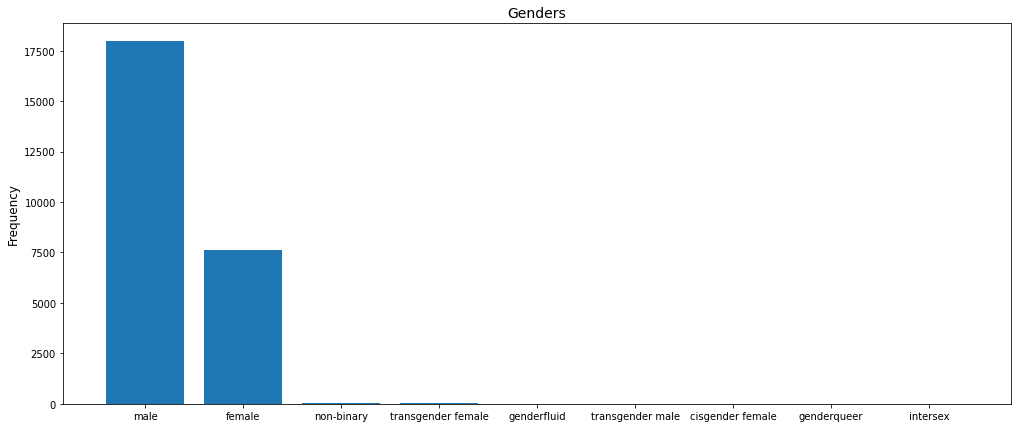

In [15]:
# Visualisation of gender distribution
# TODO: As sns plot... and depending on newspaper
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (17,7))
ax.bar(convert(df_2020["gender"]).value_counts().index,
        convert(df_2020["gender"]).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Genders", size = 14)

A expected, the minorities are almost negligible in comparison to the two main genders. But it is still very intesting to notice their presence even in small numbers. We could make a further analysis on them but first we will concentrate on the repartition between male and female. Unsurprsingly, male speakers are quoted two times more than female ones. 

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]


In [47]:
# Creation of datafram, male speakers
males = df_2020[df_2020['gender'].apply(lambda x: any(['male' in x]))]
#we only keep genders that have one item 'male'
males['gender'] = males['gender'].apply(lambda x: x[0])
males.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,male,[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian]
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,male,None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun]
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,male,[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun]
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,male,None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian]
5,2020-01-03-030623,I'm not in medieval times!,Robin Van Persie,male,[Kingdom of the Netherlands],[association football player],Q2339,2020-01-03 22:32:10,94,[https://www.thesun.co.uk/sport/football/10666...,[The Sun]


In [46]:
# Creation of datafram, female speakers
females = df_2020[df_2020['gender'].apply(lambda x: any(['female' in x]))]
#we only keep genders that have one item 'female'
females['gender'] = females['gender'].apply(lambda x: x[0])

females.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,female,[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times]
8,2020-04-08-075398,Your positivity on screen makes so many people...,HOLLY Willoughby,female,[United Kingdom],"[television presenter, model]",Q1395713,2020-04-08 07:10:04,1,[https://www.thesun.co.uk/tvandshowbiz/1135207...,[The Sun]
12,2020-01-07-028035,I saw Snoop Dogg and given the fact I have met...,Nicole Scherzinger,female,[United States of America],"[actor, singer, dancer, musician, composer, re...",Q167696,2020-01-07 22:30:07,1,[https://www.thesun.co.uk/tvandshowbiz/1069315...,[The Sun]
26,2020-02-12-041734,I won't be staying by myself tonight.,Kelly Brook,female,[United Kingdom],"[actor, model, film actor, television presenter]",Q255060,2020-02-12 22:34:08,104,[https://www.thesun.co.uk/tvandshowbiz/1095236...,[The Sun]
29,2020-02-24-048695,"She's got as hammock, going back to my jungle ...",JACQUELINE Jossa,female,[United Kingdom],[actor],Q6120126,2020-02-24 12:16:46,1,[https://www.thesun.co.uk/tvandshowbiz/1102843...,[The Sun]


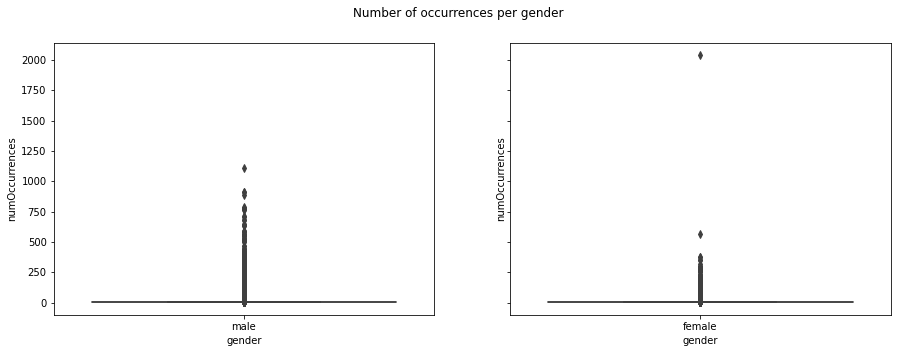

In [48]:
# Distribution of male and female speakers regarding the number of occurrences of quotes
fig, axs = plt.subplots(1,2, sharey='row')
sns.boxplot(x ='gender', y = 'numOccurrences',data=males, ax = axs[0])
sns.boxplot(x='gender', y='numOccurrences', data = females, ax = axs[1])
fig.suptitle('Number of occurrences per gender')
fig.set_size_inches(15,5)
plt.show()

In [ ]:
# quotes that we could consider as outliers??
# females.loc[females.numOccurrences >= 300]
# males.loc[males.numOccurrences >= 700]

Seeing the distribution regarding the number of occurrences of quotes from male and female speakers, we can clearly see a stronger presence of male speakers in the newspapers. This support our hypothesis of a domination by men in this domain. This raises further questions for our analysis concerning: the evolution of this domination throughout the years and depending on different countries, the themes aborded by different genders or the representation of gender minorities 